# INFERINDO DESCRIÇÕES DE VAGAS COM NER BERTIMBAU TREINADO + SBERT

## RERQUIREMENTS

In [13]:
import openai
import pandas as pd
from tqdm import tqdm
from openai import AzureOpenAI
import json
from transformers import AutoModel, AutoTokenizer
import numpy as np
from datetime import date
from math import log
import pyodbc
import warnings
import re
from unidecode import unidecode
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import torch

## GERANDO E MANIPULANDO A BASE DE DADOS

In [3]:
data_match = date.today().strftime("%Y-%m-%d")

server = 'SRVVPRDGPA01.senac.br'
database = 'DBMercadoTrabalho'
username = 'SRV_DMT'
password = 'lEJA6EiFabpcnR1f2qzLRXnb'
driver = '{ODBC Driver 17 for SQL Server}'
conn_str = (
    f"DRIVER={driver};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
)
conn = pyodbc.connect(conn_str)
query = "SELECT source, identifier, uuid, title, title_standardized, description  FROM job_vacancy.job_vacancy_post where source = 'BNE' ORDER BY NEWID()"
vagas = pd.read_sql(query, conn)
vagas = vagas.drop_duplicates()
vagas['description'].head(10)
vagas = vagas.dropna(subset=['description'])
vagas

,source,identifier,uuid,title,title_standardized,description
1,BNE,4201021,AB8A3056-D563-48EA-83A1-79F74D00DB3B,recepcionista,recepcionista,Descrição Geral\nEmpresa localizada na cidade ...
3,BNE,4036716,64407C63-C80A-49EC-9963-A9813641F199,assistente financeiro,assistente financeiro,Descrição Geral\nEmpresa localizada na cidade ...
4,BNE,4312456,9D515F44-FCC1-4F69-AFA3-903E293CCBD9,entregador,entregador,Descrição Geral\nEmpresa localizada na cidade ...
5,BNE,4103124,FDC6CE64-3F4A-46B6-A692-2D21CF1980BD,eletricista,eletricista,Descrição Geral\nEmpresa localizada na cidade ...
6,BNE,4324747,E655D8F5-2C72-4575-9C44-68B852F9380B,assistente de departamento pessoal,assistente departamento pessoal,Descrição Geral\nEmpresa localizada na cidade ...
...,...,...,...,...,...,...
566059,BNE,4216163,972BB724-F72B-494B-889B-7E0540AF93B2,analista de recursos humanos,analista recursos humanos,Descrição Geral\nEmpresa localizada na cidade ...
566060,BNE,4181104,85B63A37-14FE-4346-8747-BC01BF8A9AE3,auxiliar de serviços gerais,auxiliar servicos gerais,Descrição Geral\nEmpresa localizada na cidade ...
566061,BNE,4095490,FEF8560F-73F4-40E7-84B8-37A55803A7D9,duteiro,duteiro,Descrição Geral\nEmpresa localizada na cidade ...
566063,BNE,4298715,06E7772B-880B-4178-B373-BEFF86FBDDFE,Mecânico de Manutenção,mecanico manutencao,Descrição Geral\nEmpresa localizada na cidade ...


In [4]:
def processar_descricao(texto):
    if not isinstance(texto, str):
        return {"descricao_limpa": "", "ramo_atividade": None}

    texto_original = texto
    texto_ascii = unidecode(texto_original)

    # Corrigir quebras de linha (literal ou real)
    texto_ascii = texto_ascii.replace("\\n", "\n").replace("\\r", "\n").replace("\r", "\n")
    
    # Extrair ramo após "do ramo ... contrata"
    ramo_match = re.search(r'do ramo\s+([^\n,]+)', texto_ascii, flags=re.IGNORECASE)
    ramo = ramo_match.group(1).strip() if ramo_match else None

    # Remover tudo até e incluindo "contrata"
    texto_limpo = re.sub(r'^.*?contrata', '', texto_original, flags=re.IGNORECASE)

    # Trocar quebras por espaço
    texto_limpo = texto_limpo.replace("\\n", " ").replace("\n", " ").replace("\r", " ")

    # Corrigir "nnossa", "natendimento", etc.
    texto_limpo = re.sub(r'\b[nN](?=\w)', '', texto_limpo)

    # Limpeza adicional
    texto_limpo = re.sub(r'Tipo de V[ií]nculo.*?(?=\n|$)', '', texto_limpo, flags=re.IGNORECASE)
    texto_limpo = re.sub(r'Atribuições?\s*:?[\n]?', '', texto_limpo, flags=re.IGNORECASE)
    texto_limpo = re.sub(r'Requisitos?\s*:?[\n]?', '', texto_limpo, flags=re.IGNORECASE)
    texto_limpo = re.sub(r'Escolaridade.*?(?=\n|$)', '', texto_limpo, flags=re.IGNORECASE)
    texto_limpo = re.sub(r'Remuneraç[aã]o.*?(?=\n|$)', '', texto_limpo, flags=re.IGNORECASE)
    texto_limpo = re.sub(r'#\w+', '', texto_limpo)
    texto_limpo = re.sub(r'[^\w\s.,:\n-]', '', texto_limpo)
    texto_limpo = re.sub(r'\s*-\s*', ' ', texto_limpo)
    texto_limpo = re.sub(r'\s{2,}', ' ', texto_limpo)

    texto_limpo = texto_limpo.strip().lower()

    return {
        "descricao_limpa": texto_limpo,
        "ramo_atividade": ramo.lower() if ramo else None
    }
resultado = vagas["description"].apply(processar_descricao).apply(pd.Series)
vagas["descricao_clean"] = resultado["descricao_limpa"]
vagas["ramo_atividade"] = resultado["ramo_atividade"] 
vagas

,source,identifier,uuid,title,title_standardized,description,descricao_clean,ramo_atividade
1,BNE,4201021,AB8A3056-D563-48EA-83A1-79F74D00DB3B,recepcionista,recepcionista,Descrição Geral\nEmpresa localizada na cidade ...,"recepcionista.,vaga para portaria e recepção. ...",administrativo
3,BNE,4036716,64407C63-C80A-49EC-9963-A9813641F199,assistente financeiro,assistente financeiro,Descrição Geral\nEmpresa localizada na cidade ...,"assistente financeiro.,assistente financeiro a...",financeiro
4,BNE,4312456,9D515F44-FCC1-4F69-AFA3-903E293CCBD9,entregador,entregador,Descrição Geral\nEmpresa localizada na cidade ...,"entregador.,atividades: realização de entregas...",logistica
5,BNE,4103124,FDC6CE64-3F4A-46B6-A692-2D21CF1980BD,eletricista,eletricista,Descrição Geral\nEmpresa localizada na cidade ...,"eletricista.,ensino médio completo. conhecimen...",manutencao
6,BNE,4324747,E655D8F5-2C72-4575-9C44-68B852F9380B,assistente de departamento pessoal,assistente departamento pessoal,Descrição Geral\nEmpresa localizada na cidade ...,"assistente de departamento pessoal.,assistente...",recursos humanos
...,...,...,...,...,...,...,...,...
566059,BNE,4216163,972BB724-F72B-494B-889B-7E0540AF93B2,analista de recursos humanos,analista recursos humanos,Descrição Geral\nEmpresa localizada na cidade ...,"analista de recursos humanos.,empresa de terce...",recursos humanos
566060,BNE,4181104,85B63A37-14FE-4346-8747-BC01BF8A9AE3,auxiliar de serviços gerais,auxiliar servicos gerais,Descrição Geral\nEmpresa localizada na cidade ...,"auxiliar de serviços gerais.,escala. terça a d...",limpeza
566061,BNE,4095490,FEF8560F-73F4-40E7-84B8-37A55803A7D9,duteiro,duteiro,Descrição Geral\nEmpresa localizada na cidade ...,"duteiro.,atuação o rio de janeiro. salário com...",manutencao
566063,BNE,4298715,06E7772B-880B-4178-B373-BEFF86FBDDFE,Mecânico de Manutenção,mecanico manutencao,Descrição Geral\nEmpresa localizada na cidade ...,"mecânico de manutenção., conhecimento em siste...",manutencao


In [6]:
base_inferencia = vagas.sample(10000).copy()
base_inferencia

,source,identifier,uuid,title,title_standardized,description,descricao_clean,ramo_atividade
350985,BNE,3938500,9CAE951E-42E4-44D5-BF50-7C32478BCE4E,auxiliar administrativo,auxiliar administrativo,Descrição Geral\nEmpresa localizada na cidade ...,"auxiliar administrativo.,atuar como apoio para...",administrativo
471696,BNE,4263396,423ECB4B-C16F-48AF-9C0A-BCCE552B70A3,supervisor operacional,supervisor operacional,Descrição Geral\nEmpresa localizada na cidade ...,"supervisor operacional.,vaga de supervisor ope...",producao
283000,BNE,4270468,DD747DCE-4E9F-4FED-8F6A-FBBDD94B0077,Desenvolvedor php,desenvolvedor php,Descrição Geral\nEmpresa do segmento industria...,descrição geral empresa do segmento industrial...,None
100614,BNE,4309693,3733ACF8-9807-4948-92D8-B303CCE1CE9F,técnico eletrônico,tecnico eletronico,Descrição Geral\nEmpresa localizada na cidade ...,"técnico eletrônico.,responsabilidades e desenv...",eletronico
382283,BNE,4033199,0EBE96B2-B9B6-4C3E-A61B-50D52B71CA5E,Inspetor de alunos,inspetor alunos,"Descrição Geral\n- salário: R$ 813,65\n- data ...","descrição geral salário: r 813,65 data de iníc...",None
...,...,...,...,...,...,...,...,...
562397,BNE,4383295,66A3B332-44A0-4980-84A6-C1B846F489E3,operador de glp,operador glp,Descrição Geral\nEmpresa localizada na cidade ...,"operador de glp.,o operador de loja realiza a ...",energia
198335,BNE,4329112,03F547BB-489F-4D91-BEBE-687B8EF67A27,analista desenvolvedor,analista desenvolvedor,Descrição Geral\nEmpresa localizada na cidade ...,"analista desenvolvedor.,vaga de analista desen...",informatica
322864,BNE,3941595,88056C34-ED89-4515-B01E-097449A42F36,gerente de vendas,gerente vendas,Descrição Geral\nEmpresa localizada na cidade ...,"gerente de vendas.,osso cliente é um important...",comercio
170762,BNE,3966502,887592BB-9C58-4BC6-BC68-F2F9C3AC74F1,motorista,motorista,Descrição Geral\nEmpresa localizada na cidade ...,"motorista.,transportar itens pequenos da empre...",logistica


## ETAPA 1 - BERTIMBAU (ner)

### CARREGANDO MODELO BERTIMBAU E APLICANDO NA BASE

In [31]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import pandas as pd

# 1. Carregar modelo e tokenizer
model_path = "bertimbau_ner_final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
model.eval()

# 2. Labels
id2label = model.config.id2label

# 3. Função de inferência para uma descrição
def inferir_spans(texto, origem="vaga"):
    tokens = tokenizer(
        texto,
        return_offsets_mapping=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    offsets = tokens.pop("offset_mapping")  # Remove antes de passar ao modelo

    with torch.no_grad():
        outputs = model(**tokens)

    predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()
    tokens_decoded = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
    offsets = offsets[0].numpy()

    spans = []
    current = None

    for idx, (pred_id, (start, end)) in enumerate(zip(predictions, offsets)):
        label = id2label[pred_id]
        word = texto[start:end]
        if label == "O":
            if current:
                spans.append(current)
                current = None
            continue

        prefix, entity = label.split("-", 1)

        if prefix == "B":
            if current:
                spans.append(current)
            current = {"label": entity, "text": word, "start": start, "end": end}
        elif prefix == "I" and current and current["label"] == entity:
            current["text"] += " " + word
            current["end"] = end
        elif prefix == "L" and current and current["label"] == entity:
            current["text"] += " " + word
            current["end"] = end
            spans.append(current)
            current = None
        elif prefix == "U":
            if current:
                spans.append(current)
            spans.append({"label": entity, "text": word, "start": start, "end": end})
            current = None
        else:
            if current:
                spans.append(current)
            current = None

    if current:
        spans.append(current)

    for s in spans:
        s["source"] = origem
    return spans


In [32]:
resultados = []

for i, row in base_inferencia.iterrows():
    spans = inferir_spans(row["descricao_clean"], origem=row.get("id", i))
    for span in spans:
        span["vaga_id"] = row["identifier"]
        span["descricao"] = row["descricao_clean"]
        # adicionar identifier
        span["identifier"] = row["identifier"]
        resultados.append(span)


df_ner = pd.DataFrame(resultados)
df_ner['source'] = 'BERTIMBAU_NER'
df_ner

,label,text,start,end,source,vaga_id,descricao,identifier
0,Habilidades,atendimento telef ônico,93,115,BERTIMBAU_NER,3938500,"auxiliar administrativo.,atuar como apoio para...",3938500
1,Habilidades,receb imento e organização de correspondência s,117,162,BERTIMBAU_NER,3938500,"auxiliar administrativo.,atuar como apoio para...",3938500
2,Habilidades,organização de documentos,164,189,BERTIMBAU_NER,3938500,"auxiliar administrativo.,atuar como apoio para...",3938500
3,Habilidades,preench imento de plan ilhas,191,217,BERTIMBAU_NER,3938500,"auxiliar administrativo.,atuar como apoio para...",3938500
4,Conhecimentos,pacote of fic e,255,268,BERTIMBAU_NER,3938500,"auxiliar administrativo.,atuar como apoio para...",3938500
...,...,...,...,...,...,...,...,...
33741,Habilidades,participar de eventos e feiras,939,969,BERTIMBAU_NER,3941595,"gerente de vendas.,osso cliente é um important...",3941595
33742,Conhecimentos,meio public itário,1227,1244,BERTIMBAU_NER,3941595,"gerente de vendas.,osso cliente é um important...",3941595
33743,Conhecimentos,marketing e,1246,1257,BERTIMBAU_NER,3941595,"gerente de vendas.,osso cliente é um important...",3941595
33744,Conhecimentos,informática,1280,1291,BERTIMBAU_NER,3941595,"gerente de vendas.,osso cliente é um important...",3941595


In [33]:
df_ner["label"].value_counts()

label
Habilidades         19151
Conhecimentos        8174
Atitudes_Valores     6421
Name: count, dtype: int64

In [37]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Base de dados com spans
df = df_ner.copy() 

# Cores por label
cores_label = {
    "Habilidades": "#FF4500",  #laranja
    "Conhecimentos": "#87CEFA",  #azul
    "Atitudes_Valores": "#FF69B4"  #pink
}

# Função de destaque no texto
def destacar_spans(texto, spans):
    spans = sorted(spans, key=lambda x: x["start"])
    saida = ""
    last_idx = 0
    for span in spans:
        cor = cores_label.get(span["label"], "#eee")
        saida += texto[last_idx:span["start"]]
        saida += f"<span style='background-color:{cor}; padding:2px; border-radius:3px;' title='{span['label']}'>{texto[span['start']:span['end']]}</span>"
        last_idx = span["end"]
    saida += texto[last_idx:]
    return saida.replace("\n", "<br>")

# Widgets
vaga_ids = sorted(df["vaga_id"].unique())
dropdown = widgets.Dropdown(options=vaga_ids, description="Vaga ID:")
botao = widgets.Button(description="Ver vaga", button_style='success')
saida = widgets.Output()

# Função que será chamada ao clicar no botão
def ao_clicar_botao(b):
    with saida:
        clear_output()
        vaga_id = dropdown.value
        linhas = df[df["vaga_id"] == vaga_id]
        descricao = linhas.iloc[0]["descricao"]
        spans = linhas[["label", "text", "start", "end"]].to_dict("records")
        texto_html = destacar_spans(descricao, spans)
        display(HTML(f"<div style='font-family:Arial; font-size:14px; line-height:1.5;'>{texto_html}</div>"))

botao.on_click(ao_clicar_botao)

# Exibir widgets
display(widgets.HBox([dropdown, botao]), saida)

Output()

## ETAPA 2 - SBERT

In [14]:
# Carregar a lista de competências
df_comp = pd.read_csv("lista_competencias.csv", sep=";", encoding='utf-8-sig')

# Garante que os nomes das colunas estão corretos
df_comp.columns = df_comp.columns.str.strip().str.lower()
df_comp = df_comp.rename(columns={"competencia": "text", "tipo": "label"})

# Normaliza texto
df_comp["text"] = df_comp["text"].str.strip().str.lower()
df_comp.drop_duplicates(subset="text", inplace=True)

# Embeddings SBERT da lista
modelo_sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings_comp = modelo_sbert.encode(df_comp["text"].tolist(), convert_to_tensor=True)
def spans_sbert_complementares(texto, spans_existentes, score_min=0.75, top_k=5):
    texto_lower = texto.lower()
    sentencas = [s.strip() for s in texto.split(".") if len(s.strip()) > 10]
    novos_spans = []

    for sent in sentencas:
        emb_sent = modelo_sbert.encode(sent, convert_to_tensor=True)
        scores = util.cos_sim(emb_sent, embeddings_comp)[0]

        top_indices = torch.topk(scores, top_k).indices.tolist()

        for idx in top_indices:
            score = scores[idx].item()
            termo = df_comp.iloc[idx]["text"]
            label = df_comp.iloc[idx]["label"]

            if score >= score_min and termo in texto_lower:
                if any(termo in s["text"].lower() for s in spans_existentes):
                    continue  # já capturado pelo modelo NER

                start = texto_lower.find(termo)
                end = start + len(termo)
                if start >= 0:
                    novos_spans.append({
                        "text": texto[start:end],
                        "start": start,
                        "end": end,
                        "label": label.upper(),  # HABILIDADE, CONHECIMENTO, ATITUDE_VALOR
                        "source": "Complementar_SBERT"
                    })
    return novos_spans

In [15]:
# Carregar lista de competências
df_comp.columns = df_comp.columns.str.strip().str.lower()
df_comp = df_comp.rename(columns={"competencia": "text", "tipo": "label"})

df_comp["text"] = df_comp["text"].str.strip().str.lower()
df_comp.drop_duplicates(subset="text", inplace=True)

# Embeddings
modelo_sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings_comp = modelo_sbert.encode(df_comp["text"].tolist(), convert_to_tensor=True)

In [ ]:
def spans_sbert_complementares(texto, spans_existentes, score_min=0.85, top_k=5):
    texto_lower = texto.lower()
    sentencas = [s.strip() for s in texto.split(".") if len(s.strip()) > 10]
    novos_spans = []

    for sent in sentencas:
        emb_sent = modelo_sbert.encode(sent, convert_to_tensor=True)
        scores = util.cos_sim(emb_sent, embeddings_comp)[0]
        top_indices = torch.topk(scores, top_k).indices.tolist()

        for idx in top_indices:
            score = scores[idx].item()
            termo = df_comp.iloc[idx]["text"]
            label = df_comp.iloc[idx]["label"]

            if score >= score_min and termo in texto_lower:
                if any(termo in s["text"].lower() for s in spans_existentes):
                    continue
                start = texto_lower.find(termo)
                end = start + len(termo)
                if start >= 0:
                    novos_spans.append({
                        "vaga_id": spans_existentes[0]["vaga_id"] if spans_existentes else None,
                        "text": texto[start:end],
                        "start": start,
                        "end": end,
                        "label": label.upper(),
                        "source": "2.Complementar_SBERT",
                        "descricao": texto,
                        "identifier": base_inferencia["identifier"].iloc[0]

                    })
    return novos_spans

In [ ]:
spans_complementares_total = []

for _, row in base_inferencia.iterrows():
    spans_ner = df_ner[df_ner["vaga_id"] == row["identifier"]].to_dict("records")
    spans_sbert = spans_sbert_complementares(row["descricao_clean"], spans_ner)
    for span in spans_sbert:
        span["identifier"] = row["identifier"]
        span["vaga_id"] = row["identifier"]
        span["descricao"] = row["descricao_clean"]
        spans_complementares_total.append(span)

df_sbert = pd.DataFrame(spans_complementares_total)


In [ ]:
df_ner["source"] = "1.NER_BERTIMBAU"
df_sbert["source"] = "2.Complementar_SBERT" 
df_final = pd.concat([df_ner, df_sbert], ignore_index=True)

In [ ]:
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

# 1. Função para aplicar destaque
def destacar_spans(texto, spans):
    spans = sorted(spans, key=lambda x: x["start"])
    output = ""
    last_idx = 0

    for span in spans:
        output += texto[last_idx:span["start"]]
        cor = {
            "HABILIDADES": "#d4f4dd",
            "CONHECIMENTOS": "#d0e7ff",
            "ATITUDE_VALOR": "#fbe4e6",
            "ATITUDES_VALORES": "#fbe4e6"
        }.get(span["label"].upper(), "#eee")

        estilo_extra = "border: 1px dashed #666;" if span["source"] == "2.Complementar_SBERT" else "border: none;"

        output += f'<span style="background-color:{cor}; padding:2px; border-radius:3px; {estilo_extra}" title="{span["label"]} | {span["source"]}">{texto[span["start"]:span["end"]]}</span>'
        last_idx = span["end"]

    output += texto[last_idx:]
    return output.replace("\n", "<br>")

# 2. Lista de vagas únicas
vaga_ids = df_final["vaga_id"].unique()
dropdown = widgets.Dropdown(options=vaga_ids, description="Vaga ID:")

# 3. Função para mostrar vaga
def mostrar_vaga(vaga_id):
    linhas = df_final[df_final["vaga_id"] == vaga_id]
    texto = linhas.iloc[0]["descricao"]
    spans = linhas[["label", "text", "start", "end", "source"]].to_dict("records")
    html = destacar_spans(texto, spans)
    display(HTML(f"<div style='font-family:Arial; font-size:14px; line-height:1.5;'>{html}</div>"))

# 4. Exibir
widgets.interact(mostrar_vaga, vaga_id=dropdown)

interactive(children=(Dropdown(description='Vaga ID:', options=('3938500', '4270468', '4309693', '4033199', '4…

<function __main__.mostrar_vaga(vaga_id)>

In [ ]:
# === 1. Carregar lista de competências (ajuste o caminho do arquivo se necessário)
df_comp = pd.read_csv('lista_competencias.csv', sep=';')
df_comp.columns = df_comp.columns.str.strip().str.lower()
df_comp['text'] = df_comp['competencia'].str.strip().str.lower()
df_comp['label'] = df_comp['tipo'].str.strip().str.upper()

# === 2. Gerar embeddings das competências
modelo_sbert = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_comp = modelo_sbert.encode(df_comp['text'].tolist(), convert_to_tensor=True)

# === 3. Definir thresholds por tipo (ou use apenas um score_min global se preferir)
thresholds = {
    'HABILIDADES': 0.85,
    'CONHECIMENTOS': 0.85,
    'ATITUDES_VALORES': 0.85,
    'ATITUDE_VALOR': 0.85
}

# === 4. FUNÇÃO PRINCIPAL ===
def detectar_competencias_sentencas(df_base, modelo_sbert, embeddings_comp, df_comp, score_min=0.8, top_k=5):
    resultados = []

    for _, row in df_base.iterrows():
        vaga_id = row["vaga_id"]
        descricao = row["descricao"]
        sentencas = [s.strip() for s in descricao.split(".") if len(s.strip()) >= 10]

        for sent in sentencas:
            emb_sent = modelo_sbert.encode(sent, convert_to_tensor=True)
            scores = util.cos_sim(emb_sent, embeddings_comp)[0]
            top_indices = torch.topk(scores, top_k).indices.tolist()

            for idx in top_indices:
                score = scores[idx].item()
                if score >= score_min:
                    resultados.append({
                        "vaga_id": vaga_id,
                        "descricao": descricao,
                        "sentenca": sent,
                        "competencia_detectada": df_comp.iloc[idx]["text"],
                        "tipo": df_comp.iloc[idx]["label"],
                        "similaridade": score,
                        "source": "3.SBERT_SENTENCA"
                    })

    return pd.DataFrame(resultados)

# Chamada:
base_sentenca = base_inferencia[["identifier", "descricao_clean"]].rename(
    columns={"identifier": "vaga_id", "descricao_clean": "descricao"}
)

df_sentenca = detectar_competencias_sentencas(
    base_sentenca, modelo_sbert, embeddings_comp, df_comp,
    score_min=0.85, top_k=5
)


# === 7. VISUALIZAR RESULTADO ===
print(f"Extraídas {len(df_sentenca)} competências por SBERT_sentenca")
display(df_sentenca.head())

Extraídas 954 competências por SBERT_sentenca


,vaga_id,descricao,sentenca,competencia_detectada,tipo,similaridade,source
0,4163433,"operador de produção.,atividades da vaga: cump...",zelar para que a área de trabalho atenda aos d...,limpeza e organização do ambiente de trabalho.,CONHECIMENTOS,0.876735,SBERT_SENTENCA
1,4224112,"técnico em segurança do trabalho.,r curso técn...",técnico em segurança do trabalho,atribuições do técnico em segurança do trabalho.,CONHECIMENTOS,0.934280,SBERT_SENTENCA
2,4312187,"auxiliar de departamento pessoal.,cargo: auxil...",auxiliar de departamento pessoal,estrutura do departamento de pessoal.,CONHECIMENTOS,0.851008,SBERT_SENTENCA
3,4141020,"atendente.,morar próximo ao bairro valim de me...",ter afinidade com atendimento ao cliente,qualidade no atendimento ao cliente.,CONHECIMENTOS,0.866690,SBERT_SENTENCA
4,4141020,"atendente.,morar próximo ao bairro valim de me...",ter afinidade com atendimento ao cliente,técnicas de atendimento ao cliente.,CONHECIMENTOS,0.861520,SBERT_SENTENCA


In [22]:
# Padroniza df_sentenca diretamente no formato desejado
df_sentenca_formatado = df_sentenca.rename(columns={
    "competencia_detectada": "competencia",
    "tipo": "tipo"
})[["vaga_id", "descricao", "competencia", "tipo", "source"]]

# Ajusta capitalização
df_sentenca_formatado["tipo"] = df_sentenca_formatado["tipo"].str.upper()
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

# === 1. Lista de vagas ===
vaga_ids_sent = sorted(df_sentenca["vaga_id"].unique())
dropdown_sent = widgets.Dropdown(options=vaga_ids_sent, description="Vaga ID:")

# === 2. Função de visualização ===
def mostrar_sentencas_vaga(vaga_id):
    df_vaga = df_sentenca[df_sentenca["vaga_id"] == vaga_id]
    descricao = df_vaga["descricao"].iloc[0]

    html = f"<div style='font-family:Arial; font-size:14px; line-height:1.5;'>"
    html += f"<b>Descrição da Vaga:</b><br><p>{descricao.replace(chr(10), '<br>')}</p><br>"
    html += f"<b>Sentenças com competências detectadas:</b><br><ul>"

    for _, row in df_vaga.iterrows():
        cor = {
            "HABILIDADES": "#d4f4dd",
            "CONHECIMENTOS": "#d0e7ff",
            "ATITUDE_VALOR": "#fbe4e6",
            "ATITUDES_VALORES": "#fbe4e6",
            "ATITUDES/VALORES": "#fbe4e6"
        }.get(row["tipo"].upper(), "#eee")

        html += (
            f"<li><span style='background-color:{cor}; padding:2px; border-radius:3px;'>"
            f"<b>{row['competencia_detectada']}</b></span> "
            f"({row['tipo']}, sim={row['similaridade']:.2f})<br>"
            f"<i>{row['sentenca']}</i></li><br>"
        )
    html += "</ul></div>"
    display(HTML(html))

# === 3. Mostrar Widget ===
widgets.interact(mostrar_sentencas_vaga, vaga_id=dropdown_sent)

interactive(children=(Dropdown(description='Vaga ID:', options=('3937383', '3937389', '3937419', '3939319', '3…

<function __main__.mostrar_sentencas_vaga(vaga_id)>

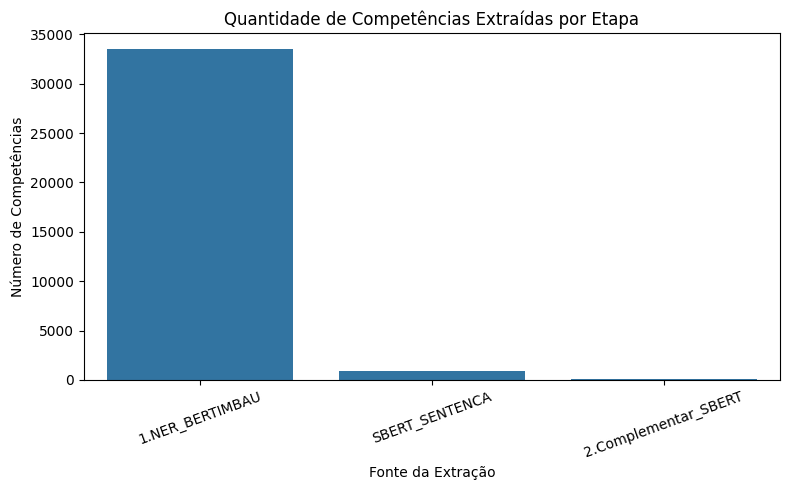

In [42]:
# 1. Padronizar e renomear colunas do df_ner
df_ner_limpo = df_ner.rename(columns={
    "text": "competencia",
    "label": "tipo"
})[["vaga_id", "descricao", "competencia", "tipo", "source"]]

# 2. Padronizar e renomear colunas do df_sbert
df_sbert_limpo = df_sbert.rename(columns={
    "text": "competencia",
    "label": "tipo"
})[["vaga_id", "descricao", "competencia", "tipo", "source"]]

# 3. Padronizar e renomear colunas do df_sentenca
df_sentenca_limpo = df_sentenca_formatado.rename(columns={
    "competencia_detectada": "competencia"
})[["vaga_id", "descricao", "competencia", "tipo", "source"]]


# 4. Unificar os 3 DataFrames
df_final_competencias = pd.concat(
    [df_ner_limpo, df_sbert_limpo, df_sentenca_limpo],
    ignore_index=True
)

# 5. Normalizar valores de tipo
df_final_competencias["tipo"] = (
    df_final_competencias["tipo"]
    .str.upper()
    .str.replace("Atitudes_valores", "ATITUDE_VALOR")
    .str.replace("ATITUDES_VALORES", "ATITUDE_VALOR")
    .str.replace("Habilidades", "HABILIDADE")
    .str.replace("Conhecimentos", "CONHECIMENTO")
    .str.strip()
)

# 6. Remover duplicações exatas
df_final_competencias = df_final_competencias.drop_duplicates()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df_final_competencias, x="source", order=df_final_competencias["source"].value_counts().index)
plt.title("Quantidade de Competências Extraídas por Etapa")
plt.xlabel("Fonte da Extração")
plt.ylabel("Número de Competências")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


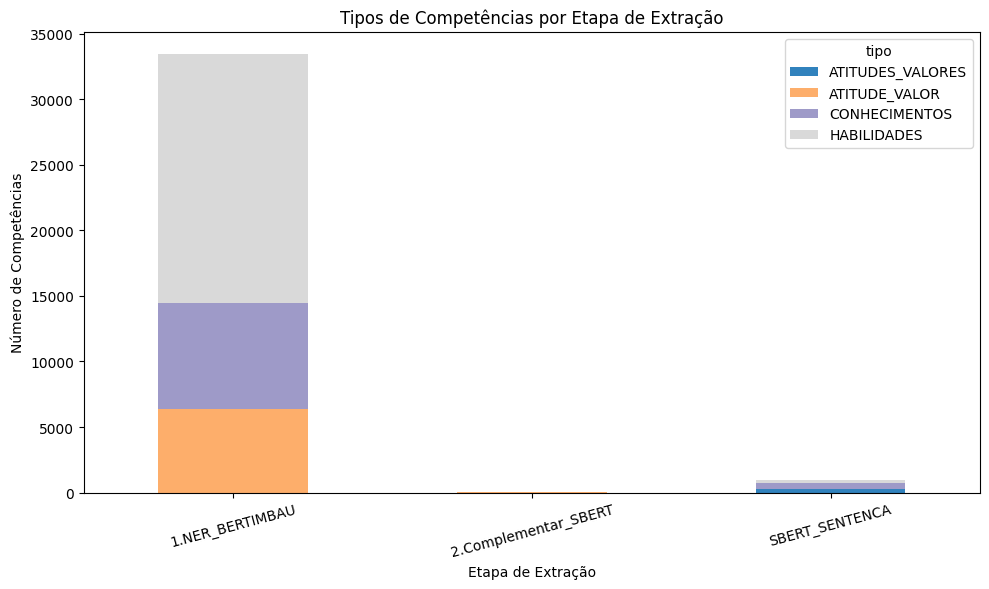

In [43]:
import pandas as pd

# Agrupamento
df_stack = df_final_competencias.copy()
df_stack["tipo"] = df_stack["tipo"].str.upper().str.replace("/", "_")  # padronizar

df_pivot = df_stack.pivot_table(index="source", columns="tipo", aggfunc="size", fill_value=0)

# Plot
df_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20c")
plt.title("Tipos de Competências por Etapa de Extração")
plt.xlabel("Etapa de Extração")
plt.ylabel("Número de Competências")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Usar df_competencias_final, que contém as colunas ['vaga_id', 'descricao', 'competencia', 'tipo', 'source']
# Agrupar para obter contagens por vaga e por source
contagens = df_final_competencias.groupby(['vaga_id', 'source']).size().reset_index(name='n_competencias')

# Tabela resumo
resumo = contagens.groupby('source')['n_competencias'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Percentual de vagas com 0 competências por etapa
# Primeiro, obter todas as combinações possíveis de vaga_id x source
todos_ids = df_final_competencias['vaga_id'].unique()
todas_etapas = df_final_competencias['source'].unique()
todas_combinacoes = pd.MultiIndex.from_product([todos_ids, todas_etapas], names=["vaga_id", "source"]).to_frame(index=False)

# Juntar com contagens reais
completo = todas_combinacoes.merge(contagens, on=['vaga_id', 'source'], how='left').fillna(0)

# Calcular percentual de vagas com 0 competências por etapa
percentual_zeros = completo.groupby('source')['n_competencias'].apply(lambda x: (x == 0).mean() * 100).reset_index(name='pct_vagas_sem_competencia')

# Mesclar tudo
resumo_final = resumo.merge(percentual_zeros, on='source')
resumo_final

,source,mean,median,min,max,pct_vagas_sem_competencia
0,1.NER_BERTIMBAU,4.526643,3.0,1,41,0.844844
1,2.Complementar_SBERT,1.012658,1.0,1,2,98.940593
2,SBERT_SENTENCA,1.873267,1.0,1,9,93.227840


In [29]:
def padronizar_labels(df, col='label'):
    return df.assign(
        **{col: df[col].str.upper().str.strip().replace({
            "ATITUDES_VALORES": "ATITUDE_VALOR",
            "ATITUDES/VALORES": "ATITUDE_VALOR"
        })}
    )

df_ner = padronizar_labels(df_ner, col="label")
df_sbert = padronizar_labels(df_sbert, col="label")
df_sentenca = padronizar_labels(df_sentenca, col="tipo")  # nessa base a coluna é "tipo"
# Renomear a coluna identifier para vaga_id (para facilitar o merge)
vagas_renomeada = vagas.rename(columns={"identifier": "vaga_id"})

# Juntar com df_ner
df_ner = df_ner.merge(vagas_renomeada[["vaga_id", "ramo_atividade", "title_standardized"]], on="vaga_id", how="left")

# Juntar com df_sbert
df_sbert = df_sbert.merge(vagas_renomeada[["vaga_id", "ramo_atividade", "title_standardized"]], on="vaga_id", how="left")

# Juntar com df_sentenca
df_sentenca = df_sentenca.merge(vagas_renomeada[["vaga_id", "ramo_atividade", "title_standardized"]], on="vaga_id", how="left")


In [45]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# === Cores por tipo de entidade ===
cores = {
    "HABILIDADES": "#d4f4dd",
    "CONHECIMENTOS": "#d0e7ff",
    "ATITUDE_VALOR": "#fbe4e6",
}

# === Função de destaque com spans ===
def destacar_spans(texto, spans, fonte=False):
    spans = sorted(spans, key=lambda x: x["start"])
    saida = ""
    last_idx = 0
    for span in spans:
        label = span["label"].upper()
        cor = cores.get(label, "#eee")
        estilo_extra = ""
        if fonte and "source" in span and "Complementar" in span["source"]:
            estilo_extra = "border: 1px dashed #333;"
        saida += texto[last_idx:span["start"]]
        saida += f"<span style='background-color:{cor}; padding:2px; border-radius:3px; {estilo_extra}' title='{label} | {span.get('source', '')}'>{texto[span['start']:span['end']]}</span>"
        last_idx = span["end"]
    saida += texto[last_idx:]
    return saida.replace("\n", "<br>")

# === Função para mostrar sentenças ===
def mostrar_sentencas(vaga_id):
    linhas = df_sentenca[df_sentenca["vaga_id"] == vaga_id]
    if linhas.empty: return "Nenhuma sentença encontrada."
    html = "<ul>"
    for _, row in linhas.iterrows():
        tipo = row["tipo"].upper()
        cor = cores.get(tipo, "#eee")
        html += (
            f"<li><span style='background-color:{cor}; padding:2px; border-radius:3px;'>"
            f"<b>{row['competencia_detectada']}</b></span> ({tipo}, sim={row['similaridade']:.2f})<br>"
            f"<i>{row['sentenca']}</i></li><br>"
        )
    html += "</ul>"
    return html

# === Legenda ===
def gerar_legenda():
    html = "<div style='margin-bottom:10px'><b>🟩 Legenda de Competências:</b><br><ul style='list-style:none; padding-left:0;'>"
    for tipo, cor in cores.items():
        html += f"<li style='margin-bottom:5px;'><span style='display:inline-block; width:20px; height:20px; background-color:{cor}; border-radius:3px; margin-right:8px;'></span>{tipo.replace('_', ' ').title()}</li>"
    html += "</ul></div><hr>"
    return html

# === Lista de vagas disponíveis ===
vaga_ids = sorted(set(df_ner["vaga_id"]) | set(df_sbert["vaga_id"]) | set(df_sentenca["vaga_id"]))
dropdown = widgets.Dropdown(options=vaga_ids, description="Vaga ID:", layout=widgets.Layout(width='50%'))

# === Área de exibição ===
saida = widgets.Output()

# === Atualização do conteúdo ===
def atualizar_widget(change):
    vaga_id = change.new
    saida.clear_output()

    with saida:
        html = gerar_legenda()

        # Buscar a descrição, mas não exibir
        descricao_base = None
        for df in [df_ner, df_sbert, df_sentenca]:
            temp = df[df["vaga_id"] == vaga_id]
            if not temp.empty:
                descricao_base = temp.iloc[0]["descricao"]
                break

        # NER
        df_vaga_ner = df_ner[df_ner["vaga_id"] == vaga_id]
        if not df_vaga_ner.empty and descricao_base:
            spans_ner = df_vaga_ner[["label", "text", "start", "end"]].to_dict("records")
            html_ner = destacar_spans(descricao_base, spans_ner)
            html += f"<h4>🔶 NER Bertimbau</h4><div style='border:1px solid #ccc; padding:10px; border-radius:5px'>{html_ner}</div><br>"

        # SBERT
        df_vaga_sbert = df_sbert[df_sbert["vaga_id"] == vaga_id]
        if not df_vaga_sbert.empty and descricao_base:
            spans_sbert = df_vaga_sbert[["label", "text", "start", "end", "source"]].to_dict("records")
            html_sbert = destacar_spans(descricao_base, spans_sbert, fonte=True)
            html += f"<h4>🔷 SBERT (complementar)</h4><div style='border:1px solid #ccc; padding:10px; border-radius:5px'>{html_sbert}</div><br>"

        # Sentenças
        df_vaga_sent = df_sentenca[df_sentenca["vaga_id"] == vaga_id]
        if not df_vaga_sent.empty:
            html_sent = mostrar_sentencas(vaga_id)
            html += f"<h4>🧩 Sentenças com competências</h4><div style='border:1px solid #ccc; padding:10px; border-radius:5px'>{html_sent}</div><br>"

        display(HTML(html))

# Conectar evento
dropdown.observe(atualizar_widget, names='value')

# Exibir
display(widgets.VBox([dropdown, saida]))
